## Graduation Research 

## MNISTのデータセットを利用して中間層出力検証方法の正確性を検証する(grad_cam検証)

## Conv2D_1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 128)       73856     
__________

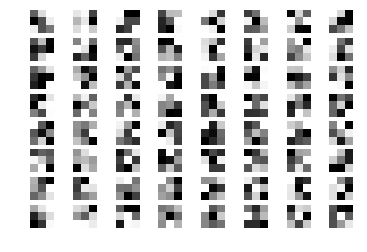

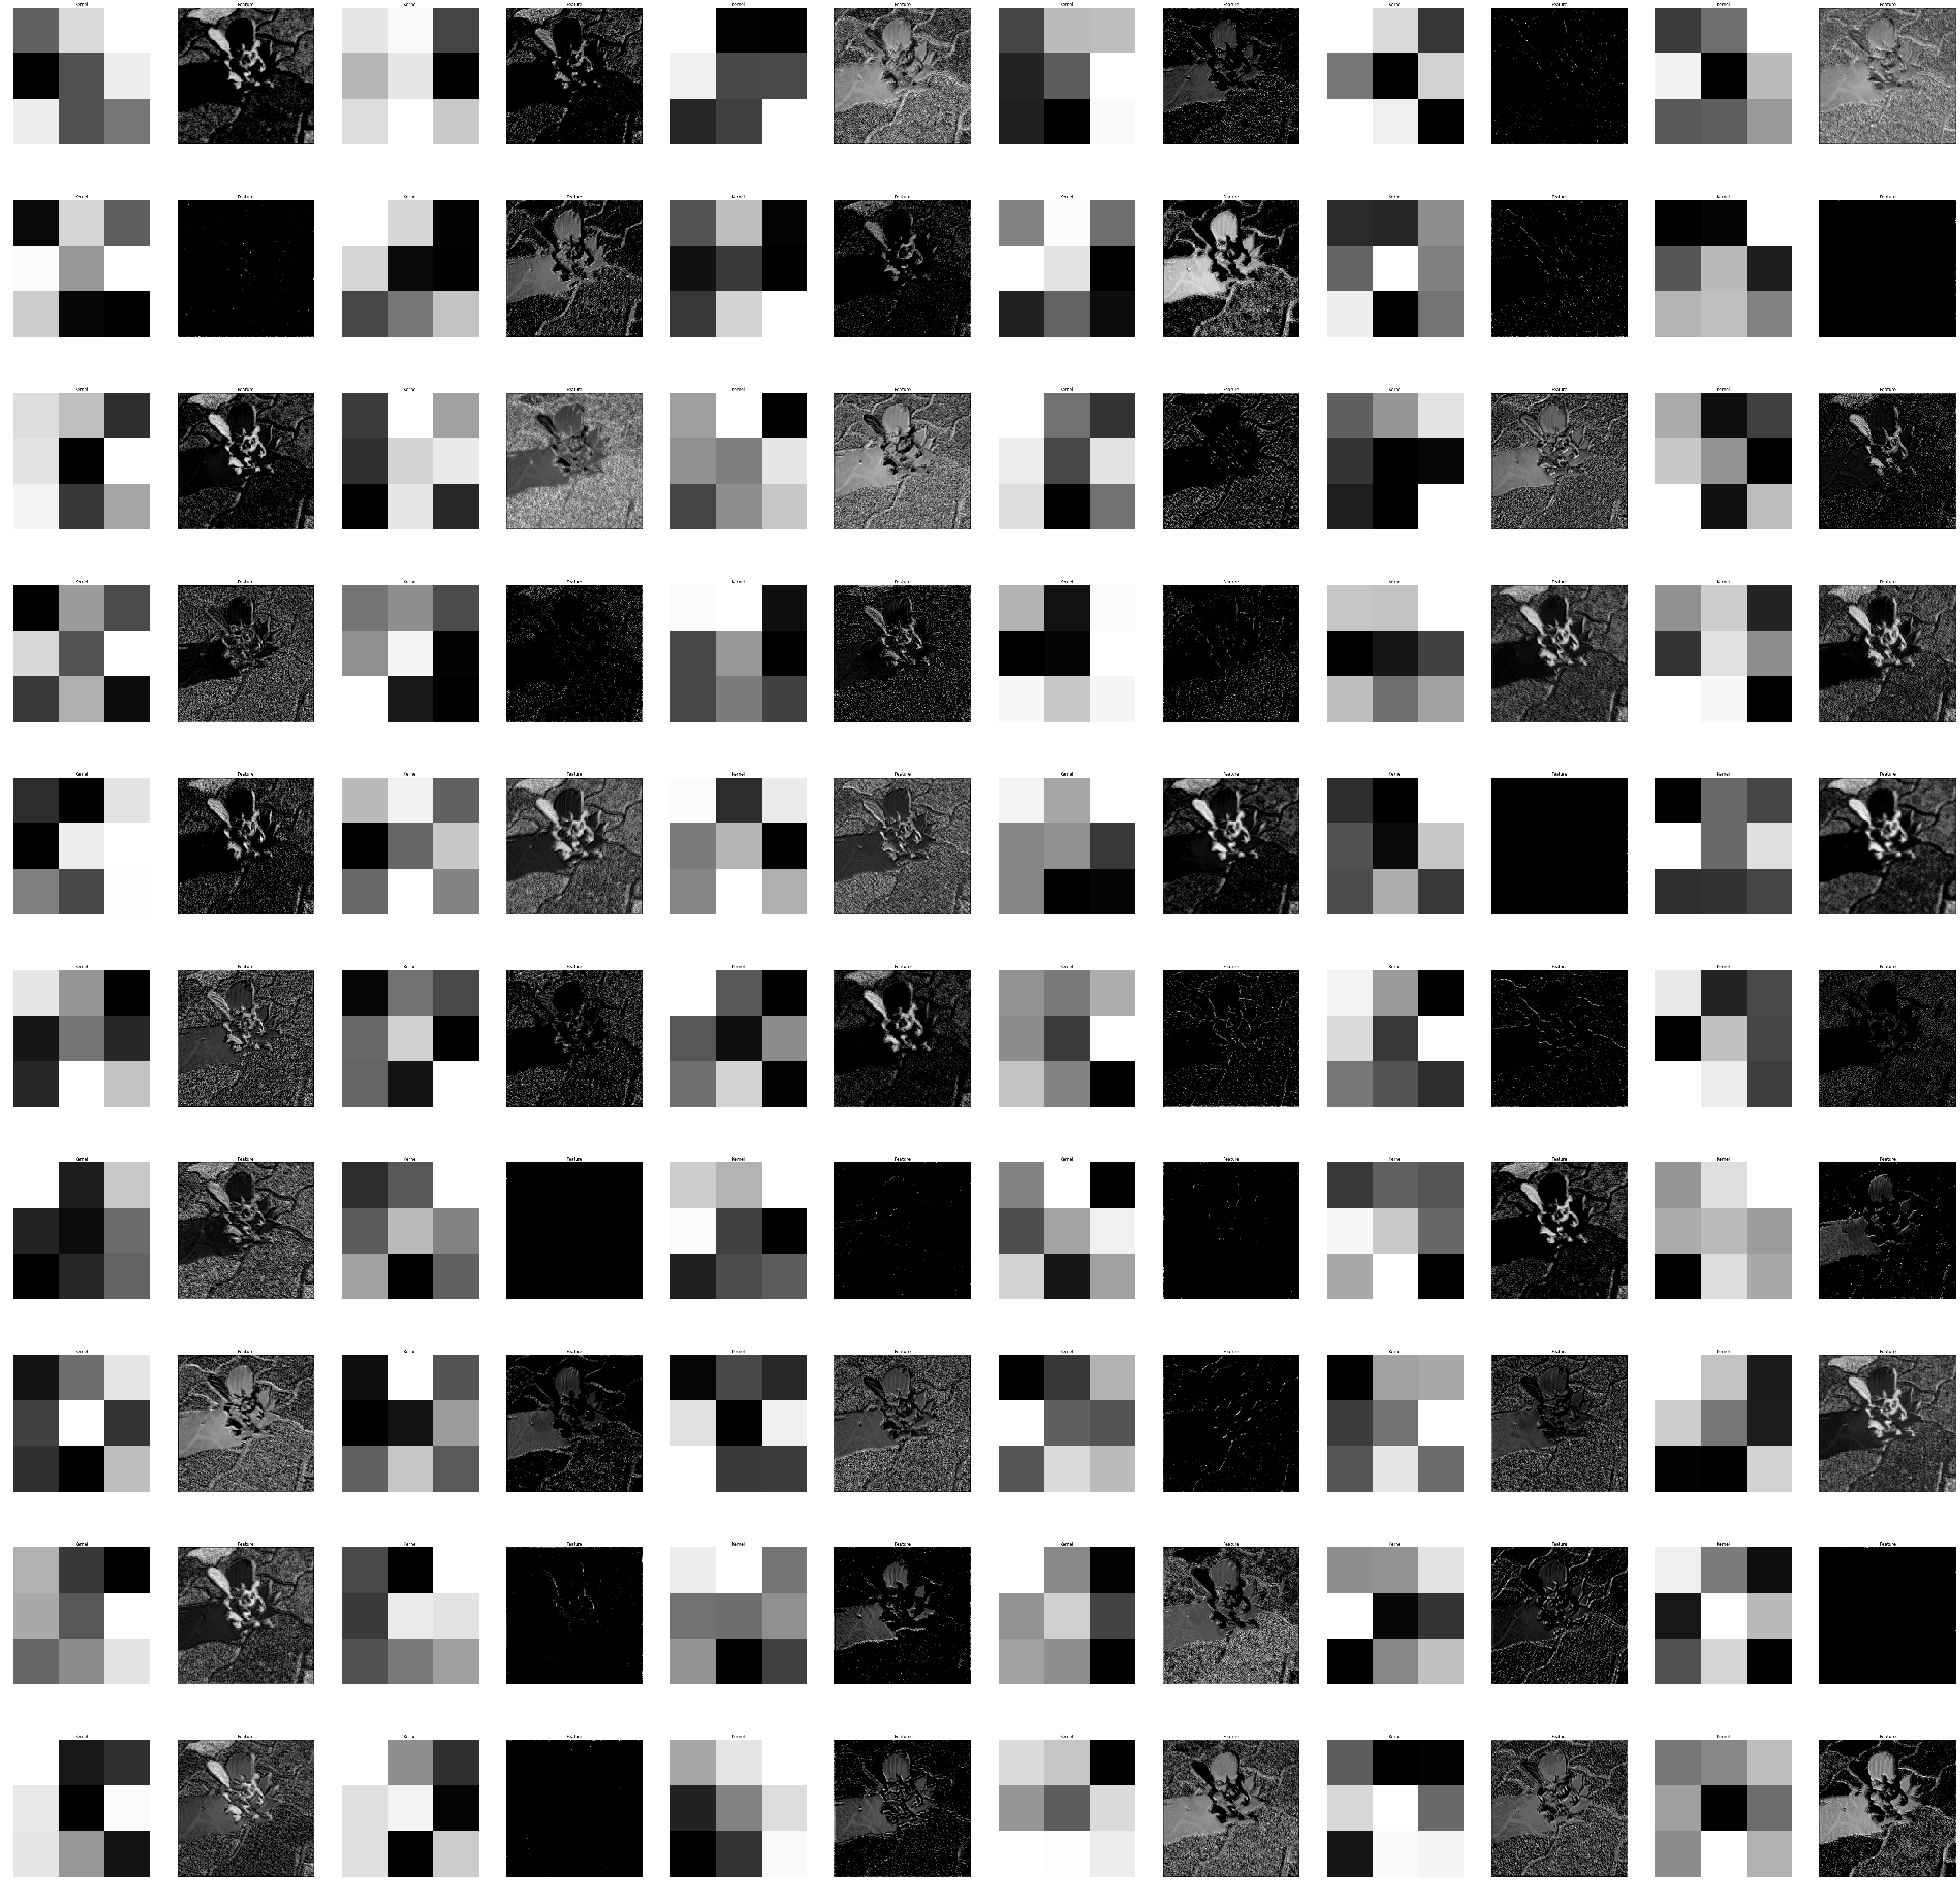

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f42b4173358>>
Traceback (most recent call last):
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [14]:
import tensorflow as tf
from sklearn import cross_validation
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
from keras.preprocessing import image
import keras

from keras.models import load_model
import random as rn
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.applications.vgg16 import VGG16, preprocess_input 
#https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras                                                                                                            

from PIL import Image
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.svm import LinearSVC

from PIL import ImageFile
import math
#from sklearn.datasets import fetch_mldata

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import numpy as np
import keras 
import sys 
import cv2

from keras.models import load_model



import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.applications.resnet50 import (ResNet50, preprocess_input)
from keras.preprocessing import image
% matplotlib inline 

import sys
# clone した convnet-drawer ディレクトリのパスを追加する。
sys.path.append('convnet-drawer')
from matplotlib_util import save_model_to_file

#画像がPILでロードできない問題について
# PILは極端に大きな画像など高速にロードできない画像はロードしないで見過ごす仕様になっている故の解決法
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 使用するGPUの割り当てを決定する
config = tf.ConfigProto(device_count={'GPU':0 ,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)


STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'


#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              

input_shape = (300, 300, 3)
batch_size = 8
epochs = 15
num_classes = 4

f_log = './logs/object_classificationAB/'
f_model = './model/test/'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'



def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(int(row[1]))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    #x /= 255
    x = (x-np.amin(x))/(np.amax(x)-np.amin(x))
    y = np.asarray(labels)
    y = tf.keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(int(row[1]))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    #test_data /= 255
    test_data = (test_data-np.amin(test_data))/(np.amax(test_data)-np.amin(test_data))
    test_label = np.asarray(labels1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label



def tf_image_translate(images, tx, ty, interpolation="NEAREST"):
    # got these parameters from solving the equations for pixel translations
    # on https://www.tensorflow.org/api_docs/python/tf/contrib/image/transform
    translations = [1, 0, -tx, 0, 1, -ty, 0, 0]
    return tf.contrib.image.translation(images, transforms, interpolation)
    
    """
    #augmentations
    if is_training():
        #color augmentations
        image = tf.image.random_brightness(image,max_delta=63)
        #image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed2) 
        #image = tf.image.random_hue(image, max_delta=0.2, seed=seed3)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
        
        tx = tf.random_normal(shape=[], mean=0.0, stddev=20.0, dtype=tf.float32)#正規分布によるランダム値 
        ty = tf.random_normal(shape=[], mean=0.0, stddev=20.0, dtype=tf.float32)
        image = tf_image_translate(image, tx=tx, ty=ty)
        
        degrees = tf.random_normal(shape=[], mean=0.0, stddev=5.0, dtype=tf.float32)
        image = tf.contrib.image.rotate(image, degrees*math.pi/180, interpolation="BILINEAR")
        
        
    """





# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


    
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, KTF.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (KTF.sqrt(KTF.mean(KTF.square(x)) + 1e-5))

def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
 #   x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) *  tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_8'):
    """
    category_index=1
    nb_classes = num_classes
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    s = input_model.layers[-1].output
    x1 = Lambda(target_layer, output_shape=target_category_loss_output_shape)(s)
    model = keras.models.Model(input_model.layers[0].input, x1)
    input_img = model.layers[0].input

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output =layer_dict[activation_layer].output
   #print(layer_output)
    max_output = KTF.max(layer_output, axis=3)
    saliency = KTF.gradients(KTF.sum(max_output), input_img)[0]
    """
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])
    
    #return KTF.function([input_img, KTF.learning_phase()], [saliency])


      
def modify_backprop(model, name):

    g = tf.get_default_graph()

    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]
        print(layer_dict)
        # replace relu activation
        for layer1 in layer_dict:
            if layer1.activation == keras.activations.relu:
                layer1.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = model
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if KTF.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


        
def grad_cam(input_model, image, category_index, layer_name):
  
    nb_classes = num_classes
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    conv_output =model.layers[9].output #model.layers[5].output 
    print(conv_output)
    #print(conv_output =  [l for l in input_model.layers if l.name == layer_name][0].output)
    
    loss = KTF.sum(model.layers[-1].output)
    print("~~~~~~")

    grads = normalize(KTF.gradients(loss, conv_output)[0])
    gradient_function = KTF.function([model.layers[0].input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    #多分GAP
    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w*(255*output[:, :, i])

    cam = cv2.resize(cam, (300, 300))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    
    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam1 = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam1) + np.float32(255*image)
    cam = 255 * cam / np.max(cam)
    cv2.imwrite("heat.jpg",cam1)
    return np.uint8(cam), heatmap



def check_accuracy_rate(model):
    path_and_label_and_weather = []
    with open("./path_and_label_test.txt","r") as s:
            image_urls=s.readlines()
    
    for i in image_urls:
            url_and_label=i.strip(" ").split(" ")
            image_url = url_and_label[0]
            image_label=url_and_label[1]
            img = image.load_img(image_url, target_size=(300,300))
            img=image.img_to_array(img)
            img.astype("float32")
            img/=255.0
            predictions=model.predict(np.expand_dims(img,axis=0))
            predicted_label=np.argmax(predictions)
            if int(predicted_label) != int(image_label):
                t=image_url.split("/")
                count=0
                for s in t:
                    if s=="dataset_valid":
                        name=t[count+1]
                    count+=1
                path_and_label_and_weather.append([image_url,name,predicted_label,int(image_label)])
                
                with open("./doc/incorrect_test_images.txt","a") as f:
                    f.write(image_url+"\n")

            elif int(predicted_label) == int(image_label) :
                if (predictions[0,predicted_label] < np.float32("0.7")):
                    with open("./doc/corret_test_images.txt","a") as g:
                        g.write(image_url+"\n")
            else:
                pass
    
    df = pd.DataFrame(path_and_label_and_weather,columns=["path","weater","predicted_label","label"])
    #df=df.set_index("weater")
    df.to_csv("./doc/incorrect_test_images.csv")
        

        

def main():

   # x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
#                                                                              "path_and_label_test.txt")

  #  old_session = KTF.get_session()

    with tf.Graph().as_default():
        session = tf.Session('')
        
        KTF.set_session(session)
        """
        KTF.set_learning_phase(1)#(0 = test, 1 = train) これがGrad-CAMをダメにしていた！！！　Grad-CAM使うときはコメントアウトすること
       # saver = tf.train.import_meta_graph("./tmp/model.ckpt.meta")
        #saver.restore(session, "./tmp/model.ckpt")

        
        model = Sequential()                                                                                                
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_initializer="he_normal", bias_initializer="zeros"))                                                                         
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))                                                                    
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Flatten())                                                                                                
        model.add(Dense(512, activation='relu', init='he_uniform'))          # どのようにハイパーパラメータ512を決めるのか→https://stackoverflow.com/questions/36950394/how-to-decide-the-size-of-layers-in-keras-dense-method                                                
        #model.add(Dropout(0.5))                                                                                             
        model.add(Dense(num_classes, activation='softmax')) # num_classes = 2値分類                                         
    
                                                                                                                            
 
       # load trained model                                                                                                
        #json_string = open(os.path.join(f_model, model_filename)).read()
        #model = model_from_json(json_string)
        #model.load_weights(os.path.join(f_model, weights_filename))
        """
        model = load_model('./model/test/Mymodel2.h5')
        print(model.summary())
     #   save_model_to_file(model,'4class_shisa_net.pdf')

        """
        model.compile(loss=keras.losses.categorical_crossentropy,                                                           
                      optimizer="SGD",                                                                                      
                      metrics=['accuracy'])                                                                                 
                                                                                                                            
        print(model.summary())                                                                                              
                                                                                                                            
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=batch_size)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   

       # saver = tf.train.Saver()
        #save_path=saver.save(session, "./tmp/model.ckpt")
        model.save('./model/test/Mymodel2.h5')
        """

        #テスト画像全ての正誤を取得
        #check_accuracy_rate(model)
    
#        img = image.load_img("/home/seimei/brush.jpg", target_size=(300, 300))

    # add for TeonsorBoard                                                                                                                                  
        """
   # KTF.set_session(old_session)
        url="/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"
    #'/home/seimei/Graduation_Research/dataset/kumori/kumori_D2/image_0001.jpg'  なるほどね
    #"/home/seimei/Graduation_Research/dataset_valid/hare/hare_D4/image_0189.jpg"
    #"/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg"
    #"/home/seimei/Graduation_Research/dataset_valid/hare/hare_D4/image_0024.jpg"
        img = image.img_to_array(img_to_matrix(url))
        img.astype('float32')
        img /= 255.0
        img = np.expand_dims(img,axis=0)
           # preprocessed_input = load_image("/home/seimei/image_0058_brush.jpg")
        predictions=model.predict(img)#np.expand_dims(img, axis=0))

        
        predicted_class= np.argmax(predictions)
        print(predicted_class)
        print(predictions)
        cam, heatmap = grad_cam(model, img, predicted_class, "conv2d_6")
        cv2.imwrite("gradcam.jpg", cam)
        cv2.imwrite("test_heatmap.jpg", heatmap)
        register_gradient()
        guided_model = modify_backprop(model, 'GuidedBackProp')
        saliency_fn = compile_saliency_function(guided_model)
        saliency = saliency_fn([img,0])#[np.expand_dims(img, axis=0), 0])
        print(saliency)
        gradcam = saliency[0] * heatmap[..., np.newaxis]
        #  print(type(gradcam))
        cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))
        """
        
   #     ========================================================== 重みの可視化       
        img = image.load_img("/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg", target_size=(300, 300))  # 画像を読み込む。
        x = image.img_to_array(img)  # PIL オブジェクトを numpy 配列にする。
        x = np.expand_dims(x, axis=0)  # ミニバッチにするため、次元を追加する。
        x = preprocess_input(x)  # ResNet 用の前処理を行う。

        # モデルの3層目の出力を返す関数を作成する。
        get_feature_map = KTF.function([model.input, KTF.learning_phase()], [model.layers[3].output])
        print(model.layers[3].output)
        # 順伝搬して特徴マップを取得する。
        features = get_feature_map([x, False])[0]
        print('features.shape', features.shape)  # features.shape (1, 112, 112, 64)

        # 重みを取得する。
        [weights, bias] = model.layers[3].get_weights()
        print(model.layers[3])
        print('layer.name', model.layers[3].name)  # layer.name bn_conv1
        print('weights.shape', weights.shape)  # weights.shape (7, 7, 3, 64)
        print('bias.shape', bias.shape)  # bias.shape (64,)


        # 特徴マップをカーネルごとに分割し、画像化する。
        feature_imgs = []
        for f in np.split(features, 64, axis=3):
            f = np.squeeze(f, axis=0)  # (1, FeatureH, FeatureW, FeatureC) -> (FeatureH, FeatureW, FeatureC)
            f = image.array_to_img(f)  # 特徴マップを画像化する。
            f = np.array(f)  # PIL オブジェクトを numpy 配列にする。
            feature_imgs.append(f)
        
        weights = weights.transpose(3,2,0,1) #配列を転置
        nb_filter, nb_channel, nb_row, nb_col = weights.shape
        print("nb_filter:{}".format(nb_filter), "nb_channel:{}".format(nb_channel),"nb_row:{}".format(nb_row),"nb_col:{}".format(nb_col))
        from sklearn.preprocessing import MinMaxScaler
        plt.figure()
        for i in range(nb_filter):
            im=weights[i,0]
            #重みを0-255のスケールに変換
           # scaler=MinMaxScaler(feature_range=(0,255))
           # im = scaler.fit_transform(im)
            #プロットを1つの図にまとめる 

            plt.subplot(8,8,i+1)
            plt.axis('off')
            plt.imshow(im, cmap='gray')
        plt.savefig("weight.png")
        plt.show()

        cols = 6
        rows = int(len(feature_imgs) / cols)
        fig, axes = plt.subplots(rows, cols * 2, figsize=(100, 100))

        for r in range(rows):
            for c in range(cols):
                i = r * cols + c
                w_axis, f_axis = axes[r, c * 2], axes[r, c * 2 + 1]

                w_axis.imshow(weights[i,0],cmap='gray')
                w_axis.set_title('Kernel')
                w_axis.axis('off')

                f_axis.imshow(feature_imgs[i], cmap='gray')
                f_axis.set_title('Feature')
                f_axis.axis('off')
        plt.savefig("weight2.png")
        plt.show()

        session.close()
    sess.close()
    
    
if __name__ == '__main__':
    main()

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1152391751511621215, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14299281323509105975
 physical_device_desc: "device: XLA_CPU device"]

## CNNにおける最終層の重み可視化

In [5]:
import tensorflow as tf
%tensorboard --logdir==./logs/object_classificationAB/events.out.tfevents.1549894103.1080ti 

UsageError: Line magic function `%tensorboard` not found.
